### Dataset Loading and testing

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
#currently installed theme will be used to
#set plot style if no arguments provided
jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]




#get the ranges of the loaded data
num_layers = X.shape[1]
num_lpoints = Y.shape[1]
size_max = np.amax(X)
size_min = np.amin(X)
size_av = 0.5*(size_max + size_min)

#this information is not given in the dataset
lam_min = 300
lam_max = 1200
lams = np.linspace(lam_min, lam_max, num_lpoints)

# X = np.expand_dims(X, 1)
# #X = np.expand_dims(X, 3)
# Y = np.expand_dims(Y, 1)
# #Y = np.expand_dims(Y, 3)






#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# normalize inputs 
x_train = (x_train - 50)/20 
x_test = (x_test - 50)/20 

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


Dataset has been loaded
x-train (60000, 8)
x-test  (40000, 8)
y-train (60000, 256)
y-test  (40000, 256)


#### Model Development

In [71]:
from keras.utils import to_channels_first
x_train = to_channels_first(x_train)


ValueError: Your data is either a textual data of shape `(num_sample, step, feature)` or a grey scale image of shape `(num_sample, rows, cols)`. Case 1: If your data is time-series or a textual data(probably you are using Conv1D), then there is no need of channel conversion.Case 2: If your data is image(probably you are using Conv2D), then you need to reshape the tension dimensions as follows:`shape = x_input.shape``x_input = x_input.reshape(shape[0], 1, shape[1], shape[2])`Note: Do not use `to_channels_fir()` in above cases.

In [6]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, UpSampling1D, Conv1D, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import PReLU


from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]



#define various models here
#naive percentage loss
def size_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_err = np.abs(y_true - y_pred)/y_true
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)


#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return np.mean(y_err)

#function to test performance on testset  
def calc_mre_K(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return K.mean(y_err)



def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(256, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'])
    return model

import timeit
#here we must have a function that calls the training routine n times and then gives avg and stddev 
# of the resulting figures
def net_performance(modelfunc, num_trials=3, batch_size=32, num_epochs=200, num_gpus=2):
    models = []
    train_err = np.ones(num_trials)
    test_err = np.ones(num_trials)
    val_err = np.ones(num_trials)
    train_time = np.ones(num_trials)
    for tnum in np.arange(num_trials):
        print("iteration: " + str(tnum + 1))
        model_curr = modelfunc()
        x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        start_time = timeit.default_timer()
        history = model_curr.fit(x_t, y_t,
                    batch_size=batch_size*num_gpus,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=(x_v, y_v))
        train_time[tnum] = timeit.default_timer() - start_time
        models.append(model_curr)
        train_err[tnum] =  (100.0/num_lpoints)*history.history['loss'][-1]/(batch_size*num_gpus)
        val_err[tnum] =   (100.0/num_lpoints)*history.history['val_loss'][-1]/(batch_size*num_gpus)
        test_err[tnum] = calc_mre(y_test, models[tnum].predict(x_test))
    return train_err, val_err, test_err, train_time

#staging area for new models 
def plot_training_history(history, factor):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(factor)
    val_loss = np.asarray(val_loss)/(factor)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,2.5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='Train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='Test error')
    axs.set_xlabel('Epoch number')
    #axs.set_ylim((0.4, 3))
    axs.set_xlim(left=1)
#     plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2]), 
#                ('0.1', '0.2', '0.3', '0.4', '0.5',  '0.75', '1.0', '1.5', '2'))
    plt.yticks(np.array([0.5, 0.75, 1.0, 1.5, 2]), 
               ('0.5',  '0.75', '1.0', '1.5', '2'))
    axs.set_ylabel('MRE (%)')
    axs.legend(loc="best")
    fig.savefig("foo2.pdf", bbox_inches='tight')

from keras.utils import to_channels_first

def conv1d_lkyrelu():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))  
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
 
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))


#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))  
    
    model.add(Flatten())
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    return model
    
    
def conv1d_model_bnorm():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first' ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    #model.add(UpSampling1D(size=5))

    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.3))
    
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
#     model.add(Dropout(0.3))

#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))    
    
    
    
    model.add(Flatten())
    # Compile model
#     if num_gpus == 1:
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#     else:
#         model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'], context = gpu_list)
    
    
    return model    

def resnetb():
    model = Sequential()
    
    #first layer6
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    model.add(Reshape((8, 32)))
    
    
    #resnet block
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
    
    
    
    #Last layer
    model.add(Flatten())
    
    #compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    
    return model


### Model testing

In [5]:
%autoreload
# import warnings
# warnings.filterwarnings('ignore')


# model = resnetb()
# #model = conv1d_lkyrelu()
# #model = conv1d_model_bnorm()
# #model = conv1d_model(1)

# #model = naiveploss_model()
# model.summary()

    
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# #SVG(model_to_dot(model).create(prog='dot', format='svg'))
 


    
    
import scnets as scn

model = scn.resnet(in_size=8,     
                   out_size=256,
                   num_units=2,
                   red_dim=16,
                   batch_size=32,
                   ker_size=3)

# model = scn.conv1dmodel(in_size=8, 
#         out_size=256,
#         batch_size=64,
#         c1_nf=64,
#         clayers=4,
#         ker_size=5)

# model = scn.convprel(in_size=8, 
#         out_size=256,
#         batch_size=64,
#         c1_nf=64,
#         clayers=4,
#         ker_size=5)

# model = scn.fullycon(in_size=8, 
#                      out_size=256, 
#                      batch_size=64,
#                      N_hidden=3, 
#                      N_neurons=36, 
#                      N_gpus=1)





# from keras import optimizers
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(model, show_shapes=False, show_layer_names=False).create(prog='dot', format='svg'))


plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model_resnet.svg')



model.summary()    
    
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_t, y_t,
                    batch_size=32,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_v, y_v))





# y_pred = model.predict(x_test)
# print(calc_mre(y_test, y_pred))



/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 256)          256         dense_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 32)        0           p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 7s 144us/step - loss: 732.8766 - calc_mre_K: 8.9462 - val_loss: 323.5366 - val_calc_mre_K: 3.9494
Epoch 2/2000
48000/48000 [==============================] - 4s 78us/step - loss: 274.1360 - calc_mre_K: 3.3464 - val_loss: 237.9160 - val_calc_mre_K: 2.9042
Epoch 3/2000
48000/48000 [==============================] - 4s 78us/step - loss: 230.6788 - calc_mre_K: 2.8159 - val_loss: 212.8244 - val_calc_mre_K: 2.5980
Epoch 4/2000
48000/48000 [==============================] - 4s 77us/step - loss: 209.2977 - calc_mre_K: 2.5549 - val_loss: 196.5989 - val_calc_mre_K: 2.3999
Epoch 5/2000
48000/48000 [==============================] - 4s 77us/step - loss: 199.4081 - calc_mre_K: 2.4342 - val_loss: 185.4336 - val_calc_mre_K: 2.2636
Epoch 6/2000
48000/48000 [==============================] - 4s 77us/step - loss: 190.9030 - calc_mre_K: 2.3304 - val_loss: 188.8548 - val_calc_mre_K: 2.3054
Epoch 7/2000
48000/48000 [==============================] - 4s 78us/st

Epoch 53/2000
48000/48000 [==============================] - 4s 78us/step - loss: 102.7360 - calc_mre_K: 1.2541 - val_loss: 111.2903 - val_calc_mre_K: 1.3585
Epoch 54/2000
48000/48000 [==============================] - 4s 78us/step - loss: 101.2462 - calc_mre_K: 1.2359 - val_loss: 96.9858 - val_calc_mre_K: 1.1839
Epoch 55/2000
48000/48000 [==============================] - 4s 76us/step - loss: 100.7244 - calc_mre_K: 1.2295 - val_loss: 109.6522 - val_calc_mre_K: 1.3385
Epoch 56/2000
48000/48000 [==============================] - 4s 77us/step - loss: 100.6261 - calc_mre_K: 1.2283 - val_loss: 107.9017 - val_calc_mre_K: 1.3172
Epoch 57/2000
48000/48000 [==============================] - 4s 76us/step - loss: 100.6158 - calc_mre_K: 1.2282 - val_loss: 108.7330 - val_calc_mre_K: 1.3273
Epoch 58/2000
48000/48000 [==============================] - 4s 78us/step - loss: 99.7550 - calc_mre_K: 1.2177 - val_loss: 101.4416 - val_calc_mre_K: 1.2383
Epoch 59/2000
48000/48000 [===========================

48000/48000 [==============================] - 4s 76us/step - loss: 85.9449 - calc_mre_K: 1.0491 - val_loss: 86.0742 - val_calc_mre_K: 1.0507
Epoch 106/2000
48000/48000 [==============================] - 4s 77us/step - loss: 85.8073 - calc_mre_K: 1.0475 - val_loss: 86.1585 - val_calc_mre_K: 1.0517
Epoch 107/2000
48000/48000 [==============================] - 4s 77us/step - loss: 85.7511 - calc_mre_K: 1.0468 - val_loss: 89.7336 - val_calc_mre_K: 1.0954
Epoch 108/2000
48000/48000 [==============================] - 4s 77us/step - loss: 85.7893 - calc_mre_K: 1.0472 - val_loss: 87.2188 - val_calc_mre_K: 1.0647
Epoch 109/2000
48000/48000 [==============================] - 4s 77us/step - loss: 85.5647 - calc_mre_K: 1.0445 - val_loss: 87.1230 - val_calc_mre_K: 1.0635
Epoch 110/2000
48000/48000 [==============================] - 4s 77us/step - loss: 85.6572 - calc_mre_K: 1.0456 - val_loss: 83.7465 - val_calc_mre_K: 1.0223
Epoch 111/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 78us/step - loss: 79.9486 - calc_mre_K: 0.9759 - val_loss: 77.8510 - val_calc_mre_K: 0.9503
Epoch 158/2000
48000/48000 [==============================] - 4s 77us/step - loss: 79.9485 - calc_mre_K: 0.9759 - val_loss: 77.8446 - val_calc_mre_K: 0.9503
Epoch 159/2000
48000/48000 [==============================] - 4s 77us/step - loss: 79.8962 - calc_mre_K: 0.9753 - val_loss: 80.6575 - val_calc_mre_K: 0.9846
Epoch 160/2000
48000/48000 [==============================] - 4s 78us/step - loss: 80.0035 - calc_mre_K: 0.9766 - val_loss: 79.2542 - val_calc_mre_K: 0.9675
Epoch 161/2000
48000/48000 [==============================] - 4s 77us/step - loss: 79.3305 - calc_mre_K: 0.9684 - val_loss: 82.2613 - val_calc_mre_K: 1.0042
Epoch 162/2000
48000/48000 [==============================] - 4s 77us/step - loss: 79.5210 - calc_mre_K: 0.9707 - val_loss: 79.5520 - val_calc_mre_K: 0.9711
Epoch 163/2000
48000/48000 [==============================] - 4s 78us/ste

48000/48000 [==============================] - 4s 79us/step - loss: 76.8737 - calc_mre_K: 0.9384 - val_loss: 75.1035 - val_calc_mre_K: 0.9168
Epoch 210/2000
48000/48000 [==============================] - 4s 79us/step - loss: 77.0310 - calc_mre_K: 0.9403 - val_loss: 75.8667 - val_calc_mre_K: 0.9261
Epoch 211/2000
48000/48000 [==============================] - 4s 79us/step - loss: 76.7276 - calc_mre_K: 0.9366 - val_loss: 74.9716 - val_calc_mre_K: 0.9152
Epoch 212/2000
48000/48000 [==============================] - 4s 79us/step - loss: 76.9187 - calc_mre_K: 0.9389 - val_loss: 78.6129 - val_calc_mre_K: 0.9596
Epoch 213/2000
48000/48000 [==============================] - 4s 79us/step - loss: 76.9713 - calc_mre_K: 0.9396 - val_loss: 79.8308 - val_calc_mre_K: 0.9745
Epoch 214/2000
48000/48000 [==============================] - 4s 79us/step - loss: 76.5212 - calc_mre_K: 0.9341 - val_loss: 75.5402 - val_calc_mre_K: 0.9221
Epoch 215/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 79us/step - loss: 75.1417 - calc_mre_K: 0.9173 - val_loss: 76.0219 - val_calc_mre_K: 0.9280
Epoch 262/2000
48000/48000 [==============================] - 4s 80us/step - loss: 74.7523 - calc_mre_K: 0.9125 - val_loss: 73.2210 - val_calc_mre_K: 0.8938
Epoch 263/2000
48000/48000 [==============================] - 4s 79us/step - loss: 74.6908 - calc_mre_K: 0.9118 - val_loss: 73.0797 - val_calc_mre_K: 0.8921
Epoch 264/2000
48000/48000 [==============================] - 4s 80us/step - loss: 74.6772 - calc_mre_K: 0.9116 - val_loss: 75.4837 - val_calc_mre_K: 0.9214
Epoch 265/2000
48000/48000 [==============================] - 4s 78us/step - loss: 75.0636 - calc_mre_K: 0.9163 - val_loss: 76.7141 - val_calc_mre_K: 0.9365
Epoch 266/2000
48000/48000 [==============================] - 4s 79us/step - loss: 74.9139 - calc_mre_K: 0.9145 - val_loss: 75.4587 - val_calc_mre_K: 0.9211
Epoch 267/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 78us/step - loss: 73.7922 - calc_mre_K: 0.9008 - val_loss: 73.9676 - val_calc_mre_K: 0.9029
Epoch 314/2000
48000/48000 [==============================] - 4s 77us/step - loss: 74.3367 - calc_mre_K: 0.9074 - val_loss: 73.9707 - val_calc_mre_K: 0.9030
Epoch 315/2000
48000/48000 [==============================] - 4s 77us/step - loss: 73.8059 - calc_mre_K: 0.9010 - val_loss: 72.0849 - val_calc_mre_K: 0.8799
Epoch 316/2000
48000/48000 [==============================] - 4s 78us/step - loss: 73.7798 - calc_mre_K: 0.9006 - val_loss: 75.3911 - val_calc_mre_K: 0.9203
Epoch 317/2000
48000/48000 [==============================] - 4s 78us/step - loss: 73.6470 - calc_mre_K: 0.8990 - val_loss: 77.0586 - val_calc_mre_K: 0.9407
Epoch 318/2000
48000/48000 [==============================] - 4s 76us/step - loss: 73.3933 - calc_mre_K: 0.8959 - val_loss: 75.9979 - val_calc_mre_K: 0.9277
Epoch 319/2000
48000/48000 [==============================] - 4s 78us/ste

48000/48000 [==============================] - 4s 77us/step - loss: 72.5572 - calc_mre_K: 0.8857 - val_loss: 74.4452 - val_calc_mre_K: 0.9088
Epoch 366/2000
48000/48000 [==============================] - 4s 77us/step - loss: 72.7852 - calc_mre_K: 0.8885 - val_loss: 71.6715 - val_calc_mre_K: 0.8749
Epoch 367/2000
48000/48000 [==============================] - 4s 76us/step - loss: 73.0503 - calc_mre_K: 0.8917 - val_loss: 72.8850 - val_calc_mre_K: 0.8897
Epoch 368/2000
48000/48000 [==============================] - 4s 79us/step - loss: 72.6005 - calc_mre_K: 0.8862 - val_loss: 71.3107 - val_calc_mre_K: 0.8705
Epoch 369/2000
48000/48000 [==============================] - 4s 79us/step - loss: 72.7364 - calc_mre_K: 0.8879 - val_loss: 73.0268 - val_calc_mre_K: 0.8914
Epoch 370/2000
48000/48000 [==============================] - 4s 78us/step - loss: 72.7198 - calc_mre_K: 0.8877 - val_loss: 72.0802 - val_calc_mre_K: 0.8799
Epoch 371/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 80us/step - loss: 71.8702 - calc_mre_K: 0.8773 - val_loss: 70.8739 - val_calc_mre_K: 0.8652
Epoch 418/2000
48000/48000 [==============================] - 4s 78us/step - loss: 72.0916 - calc_mre_K: 0.8800 - val_loss: 72.7284 - val_calc_mre_K: 0.8878
Epoch 419/2000
48000/48000 [==============================] - 4s 78us/step - loss: 71.9594 - calc_mre_K: 0.8784 - val_loss: 73.6793 - val_calc_mre_K: 0.8994
Epoch 420/2000
48000/48000 [==============================] - 4s 79us/step - loss: 71.8092 - calc_mre_K: 0.8766 - val_loss: 73.6372 - val_calc_mre_K: 0.8989
Epoch 421/2000
48000/48000 [==============================] - 4s 79us/step - loss: 72.0592 - calc_mre_K: 0.8796 - val_loss: 71.4164 - val_calc_mre_K: 0.8718
Epoch 422/2000
48000/48000 [==============================] - 4s 80us/step - loss: 71.7984 - calc_mre_K: 0.8764 - val_loss: 75.6888 - val_calc_mre_K: 0.9239
Epoch 423/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 76us/step - loss: 71.3568 - calc_mre_K: 0.8711 - val_loss: 69.7939 - val_calc_mre_K: 0.8520
Epoch 470/2000
48000/48000 [==============================] - 4s 76us/step - loss: 71.4401 - calc_mre_K: 0.8721 - val_loss: 71.0194 - val_calc_mre_K: 0.8669
Epoch 471/2000
48000/48000 [==============================] - 4s 75us/step - loss: 71.3167 - calc_mre_K: 0.8706 - val_loss: 70.0169 - val_calc_mre_K: 0.8547
Epoch 472/2000
48000/48000 [==============================] - 4s 77us/step - loss: 71.5568 - calc_mre_K: 0.8735 - val_loss: 69.5260 - val_calc_mre_K: 0.8487
Epoch 473/2000
48000/48000 [==============================] - 4s 78us/step - loss: 71.5628 - calc_mre_K: 0.8736 - val_loss: 70.2824 - val_calc_mre_K: 0.8579
Epoch 474/2000
48000/48000 [==============================] - 4s 77us/step - loss: 71.2862 - calc_mre_K: 0.8702 - val_loss: 69.7029 - val_calc_mre_K: 0.8509
Epoch 475/2000
48000/48000 [==============================] - 4s 77us/ste

48000/48000 [==============================] - 4s 77us/step - loss: 71.0675 - calc_mre_K: 0.8675 - val_loss: 71.0111 - val_calc_mre_K: 0.8668
Epoch 522/2000
48000/48000 [==============================] - 4s 78us/step - loss: 70.8438 - calc_mre_K: 0.8648 - val_loss: 73.6335 - val_calc_mre_K: 0.8988
Epoch 523/2000
48000/48000 [==============================] - 4s 78us/step - loss: 71.0938 - calc_mre_K: 0.8678 - val_loss: 76.8784 - val_calc_mre_K: 0.9385
Epoch 524/2000
48000/48000 [==============================] - 4s 76us/step - loss: 70.6672 - calc_mre_K: 0.8626 - val_loss: 71.1695 - val_calc_mre_K: 0.8688
Epoch 525/2000
48000/48000 [==============================] - 4s 75us/step - loss: 71.0190 - calc_mre_K: 0.8669 - val_loss: 70.2974 - val_calc_mre_K: 0.8581
Epoch 526/2000
48000/48000 [==============================] - 4s 75us/step - loss: 70.6845 - calc_mre_K: 0.8628 - val_loss: 72.9573 - val_calc_mre_K: 0.8906
Epoch 527/2000
48000/48000 [==============================] - 4s 76us/ste

48000/48000 [==============================] - 4s 78us/step - loss: 70.4460 - calc_mre_K: 0.8599 - val_loss: 70.8114 - val_calc_mre_K: 0.8644
Epoch 574/2000
48000/48000 [==============================] - 4s 79us/step - loss: 70.3442 - calc_mre_K: 0.8587 - val_loss: 68.7604 - val_calc_mre_K: 0.8394
Epoch 575/2000
48000/48000 [==============================] - 4s 78us/step - loss: 70.6017 - calc_mre_K: 0.8618 - val_loss: 68.9969 - val_calc_mre_K: 0.8422
Epoch 576/2000
48000/48000 [==============================] - 4s 76us/step - loss: 70.5513 - calc_mre_K: 0.8612 - val_loss: 70.7963 - val_calc_mre_K: 0.8642
Epoch 577/2000
48000/48000 [==============================] - 4s 77us/step - loss: 70.3815 - calc_mre_K: 0.8591 - val_loss: 70.2563 - val_calc_mre_K: 0.8576
Epoch 578/2000
48000/48000 [==============================] - 4s 78us/step - loss: 70.5073 - calc_mre_K: 0.8607 - val_loss: 69.2485 - val_calc_mre_K: 0.8453
Epoch 579/2000
48000/48000 [==============================] - 4s 77us/ste

48000/48000 [==============================] - 4s 75us/step - loss: 70.0730 - calc_mre_K: 0.8554 - val_loss: 69.8090 - val_calc_mre_K: 0.8522
Epoch 626/2000
48000/48000 [==============================] - 4s 79us/step - loss: 69.9742 - calc_mre_K: 0.8542 - val_loss: 70.2443 - val_calc_mre_K: 0.8575
Epoch 627/2000
48000/48000 [==============================] - 4s 81us/step - loss: 69.9923 - calc_mre_K: 0.8544 - val_loss: 68.7785 - val_calc_mre_K: 0.8396
Epoch 628/2000
48000/48000 [==============================] - 4s 82us/step - loss: 70.3250 - calc_mre_K: 0.8585 - val_loss: 68.4076 - val_calc_mre_K: 0.8351
Epoch 629/2000
48000/48000 [==============================] - 4s 81us/step - loss: 70.0047 - calc_mre_K: 0.8546 - val_loss: 70.0301 - val_calc_mre_K: 0.8549
Epoch 630/2000
48000/48000 [==============================] - 4s 81us/step - loss: 70.0964 - calc_mre_K: 0.8557 - val_loss: 69.4070 - val_calc_mre_K: 0.8473
Epoch 631/2000
48000/48000 [==============================] - 4s 80us/ste

48000/48000 [==============================] - 4s 79us/step - loss: 69.2818 - calc_mre_K: 0.8457 - val_loss: 69.4179 - val_calc_mre_K: 0.8474
Epoch 678/2000
48000/48000 [==============================] - 4s 80us/step - loss: 69.5839 - calc_mre_K: 0.8494 - val_loss: 69.3968 - val_calc_mre_K: 0.8471
Epoch 679/2000
48000/48000 [==============================] - 4s 80us/step - loss: 69.6357 - calc_mre_K: 0.8500 - val_loss: 68.0484 - val_calc_mre_K: 0.8307
Epoch 680/2000
48000/48000 [==============================] - 4s 81us/step - loss: 69.4607 - calc_mre_K: 0.8479 - val_loss: 69.1102 - val_calc_mre_K: 0.8436
Epoch 681/2000
48000/48000 [==============================] - 4s 79us/step - loss: 69.4604 - calc_mre_K: 0.8479 - val_loss: 67.9453 - val_calc_mre_K: 0.8294
Epoch 682/2000
48000/48000 [==============================] - 4s 79us/step - loss: 69.5922 - calc_mre_K: 0.8495 - val_loss: 72.2929 - val_calc_mre_K: 0.8825
Epoch 683/2000
48000/48000 [==============================] - 4s 78us/ste

48000/48000 [==============================] - 4s 80us/step - loss: 69.1756 - calc_mre_K: 0.8444 - val_loss: 70.7000 - val_calc_mre_K: 0.8630
Epoch 730/2000
48000/48000 [==============================] - 4s 76us/step - loss: 69.0619 - calc_mre_K: 0.8430 - val_loss: 69.2779 - val_calc_mre_K: 0.8457
Epoch 731/2000
48000/48000 [==============================] - 4s 76us/step - loss: 68.9835 - calc_mre_K: 0.8421 - val_loss: 68.4257 - val_calc_mre_K: 0.8353
Epoch 732/2000
48000/48000 [==============================] - 4s 75us/step - loss: 69.2267 - calc_mre_K: 0.8451 - val_loss: 67.9296 - val_calc_mre_K: 0.8292
Epoch 733/2000
48000/48000 [==============================] - 4s 77us/step - loss: 68.9465 - calc_mre_K: 0.8416 - val_loss: 68.5082 - val_calc_mre_K: 0.8363
Epoch 734/2000
48000/48000 [==============================] - 4s 77us/step - loss: 69.0907 - calc_mre_K: 0.8434 - val_loss: 69.0262 - val_calc_mre_K: 0.8426
Epoch 735/2000
48000/48000 [==============================] - 4s 78us/ste

48000/48000 [==============================] - 4s 79us/step - loss: 68.9212 - calc_mre_K: 0.8413 - val_loss: 69.5418 - val_calc_mre_K: 0.8489
Epoch 782/2000
48000/48000 [==============================] - 4s 79us/step - loss: 68.6100 - calc_mre_K: 0.8375 - val_loss: 69.3023 - val_calc_mre_K: 0.8460
Epoch 783/2000
48000/48000 [==============================] - 4s 78us/step - loss: 68.7570 - calc_mre_K: 0.8393 - val_loss: 71.9419 - val_calc_mre_K: 0.8782
Epoch 784/2000
48000/48000 [==============================] - 4s 76us/step - loss: 68.8150 - calc_mre_K: 0.8400 - val_loss: 69.4250 - val_calc_mre_K: 0.8475
Epoch 785/2000
48000/48000 [==============================] - 4s 78us/step - loss: 68.8167 - calc_mre_K: 0.8400 - val_loss: 67.8022 - val_calc_mre_K: 0.8277
Epoch 786/2000
48000/48000 [==============================] - 4s 77us/step - loss: 68.7118 - calc_mre_K: 0.8388 - val_loss: 67.8021 - val_calc_mre_K: 0.8277
Epoch 787/2000
48000/48000 [==============================] - 4s 77us/ste

48000/48000 [==============================] - 4s 80us/step - loss: 68.5398 - calc_mre_K: 0.8367 - val_loss: 66.6366 - val_calc_mre_K: 0.8134
Epoch 834/2000
48000/48000 [==============================] - 4s 81us/step - loss: 68.4766 - calc_mre_K: 0.8359 - val_loss: 68.7908 - val_calc_mre_K: 0.8397
Epoch 835/2000
48000/48000 [==============================] - 4s 81us/step - loss: 68.3508 - calc_mre_K: 0.8344 - val_loss: 68.6467 - val_calc_mre_K: 0.8380
Epoch 836/2000
48000/48000 [==============================] - 4s 80us/step - loss: 68.4523 - calc_mre_K: 0.8356 - val_loss: 68.0088 - val_calc_mre_K: 0.8302
Epoch 837/2000
48000/48000 [==============================] - 4s 80us/step - loss: 68.4229 - calc_mre_K: 0.8352 - val_loss: 69.3048 - val_calc_mre_K: 0.8460
Epoch 838/2000
48000/48000 [==============================] - 4s 79us/step - loss: 68.3646 - calc_mre_K: 0.8345 - val_loss: 67.1027 - val_calc_mre_K: 0.8191
Epoch 839/2000
48000/48000 [==============================] - 4s 80us/ste

48000/48000 [==============================] - 4s 77us/step - loss: 68.2687 - calc_mre_K: 0.8334 - val_loss: 67.8355 - val_calc_mre_K: 0.8281
Epoch 886/2000
48000/48000 [==============================] - 4s 76us/step - loss: 68.0514 - calc_mre_K: 0.8307 - val_loss: 68.8392 - val_calc_mre_K: 0.8403
Epoch 887/2000
48000/48000 [==============================] - 4s 75us/step - loss: 68.1054 - calc_mre_K: 0.8314 - val_loss: 69.6213 - val_calc_mre_K: 0.8499
Epoch 888/2000
48000/48000 [==============================] - 4s 76us/step - loss: 68.2236 - calc_mre_K: 0.8328 - val_loss: 67.8345 - val_calc_mre_K: 0.8281
Epoch 889/2000
48000/48000 [==============================] - 4s 77us/step - loss: 68.1612 - calc_mre_K: 0.8320 - val_loss: 67.1319 - val_calc_mre_K: 0.8195
Epoch 890/2000
48000/48000 [==============================] - 4s 78us/step - loss: 68.2292 - calc_mre_K: 0.8329 - val_loss: 69.0708 - val_calc_mre_K: 0.8431
Epoch 891/2000
48000/48000 [==============================] - 4s 78us/ste

48000/48000 [==============================] - 4s 76us/step - loss: 67.7235 - calc_mre_K: 0.8267 - val_loss: 73.2562 - val_calc_mre_K: 0.8942
Epoch 938/2000
48000/48000 [==============================] - 4s 76us/step - loss: 68.3821 - calc_mre_K: 0.8347 - val_loss: 68.2266 - val_calc_mre_K: 0.8328
Epoch 939/2000
48000/48000 [==============================] - 4s 76us/step - loss: 67.7575 - calc_mre_K: 0.8271 - val_loss: 67.6874 - val_calc_mre_K: 0.8263
Epoch 940/2000
48000/48000 [==============================] - 4s 76us/step - loss: 67.8212 - calc_mre_K: 0.8279 - val_loss: 71.4814 - val_calc_mre_K: 0.8726
Epoch 941/2000
48000/48000 [==============================] - 4s 75us/step - loss: 67.9176 - calc_mre_K: 0.8291 - val_loss: 68.8167 - val_calc_mre_K: 0.8400
Epoch 942/2000
48000/48000 [==============================] - 4s 75us/step - loss: 68.0088 - calc_mre_K: 0.8302 - val_loss: 68.0682 - val_calc_mre_K: 0.8309
Epoch 943/2000
48000/48000 [==============================] - 4s 74us/ste

48000/48000 [==============================] - 4s 80us/step - loss: 67.5965 - calc_mre_K: 0.8252 - val_loss: 66.2843 - val_calc_mre_K: 0.8091
Epoch 990/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.5231 - calc_mre_K: 0.8243 - val_loss: 70.6849 - val_calc_mre_K: 0.8629
Epoch 991/2000
48000/48000 [==============================] - 4s 79us/step - loss: 67.7525 - calc_mre_K: 0.8271 - val_loss: 66.9228 - val_calc_mre_K: 0.8169
Epoch 992/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.3997 - calc_mre_K: 0.8228 - val_loss: 68.3498 - val_calc_mre_K: 0.8343
Epoch 993/2000
48000/48000 [==============================] - 4s 78us/step - loss: 67.5936 - calc_mre_K: 0.8251 - val_loss: 66.9790 - val_calc_mre_K: 0.8176
Epoch 994/2000
48000/48000 [==============================] - 4s 81us/step - loss: 67.6498 - calc_mre_K: 0.8258 - val_loss: 67.6192 - val_calc_mre_K: 0.8254
Epoch 995/2000
48000/48000 [==============================] - 4s 79us/ste

48000/48000 [==============================] - 4s 76us/step - loss: 67.4032 - calc_mre_K: 0.8228 - val_loss: 68.3702 - val_calc_mre_K: 0.8346
Epoch 1042/2000
48000/48000 [==============================] - 4s 77us/step - loss: 67.6313 - calc_mre_K: 0.8256 - val_loss: 66.1339 - val_calc_mre_K: 0.8073
Epoch 1043/2000
48000/48000 [==============================] - 4s 76us/step - loss: 67.4623 - calc_mre_K: 0.8235 - val_loss: 67.6003 - val_calc_mre_K: 0.8252
Epoch 1044/2000
48000/48000 [==============================] - 4s 78us/step - loss: 67.5595 - calc_mre_K: 0.8247 - val_loss: 65.6961 - val_calc_mre_K: 0.8020
Epoch 1045/2000
48000/48000 [==============================] - 4s 77us/step - loss: 67.4620 - calc_mre_K: 0.8235 - val_loss: 65.6985 - val_calc_mre_K: 0.8020
Epoch 1046/2000
48000/48000 [==============================] - 4s 79us/step - loss: 67.4367 - calc_mre_K: 0.8232 - val_loss: 66.0648 - val_calc_mre_K: 0.8065
Epoch 1047/2000
48000/48000 [==============================] - 4s 80

Epoch 1093/2000
48000/48000 [==============================] - 4s 79us/step - loss: 67.5301 - calc_mre_K: 0.8243 - val_loss: 67.7979 - val_calc_mre_K: 0.8276
Epoch 1094/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.2745 - calc_mre_K: 0.8212 - val_loss: 68.1297 - val_calc_mre_K: 0.8317
Epoch 1095/2000
48000/48000 [==============================] - 4s 79us/step - loss: 67.4628 - calc_mre_K: 0.8235 - val_loss: 67.2156 - val_calc_mre_K: 0.8205
Epoch 1096/2000
48000/48000 [==============================] - 4s 81us/step - loss: 67.4427 - calc_mre_K: 0.8233 - val_loss: 67.8450 - val_calc_mre_K: 0.8282
Epoch 1097/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.2937 - calc_mre_K: 0.8215 - val_loss: 66.1064 - val_calc_mre_K: 0.8070
Epoch 1098/2000
48000/48000 [==============================] - 4s 81us/step - loss: 67.4178 - calc_mre_K: 0.8230 - val_loss: 67.9501 - val_calc_mre_K: 0.8295
Epoch 1099/2000
48000/48000 [=======================

Epoch 1145/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.1100 - calc_mre_K: 0.8192 - val_loss: 65.2904 - val_calc_mre_K: 0.7970
Epoch 1146/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.2173 - calc_mre_K: 0.8205 - val_loss: 68.0711 - val_calc_mre_K: 0.8309
Epoch 1147/2000
48000/48000 [==============================] - 4s 81us/step - loss: 67.0734 - calc_mre_K: 0.8188 - val_loss: 66.4757 - val_calc_mre_K: 0.8115
Epoch 1148/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.2313 - calc_mre_K: 0.8207 - val_loss: 67.5360 - val_calc_mre_K: 0.8244
Epoch 1149/2000
48000/48000 [==============================] - 4s 81us/step - loss: 67.0195 - calc_mre_K: 0.8181 - val_loss: 65.7226 - val_calc_mre_K: 0.8023
Epoch 1150/2000
48000/48000 [==============================] - 4s 80us/step - loss: 67.1817 - calc_mre_K: 0.8201 - val_loss: 68.2495 - val_calc_mre_K: 0.8331
Epoch 1151/2000
48000/48000 [=======================

Epoch 1197/2000
48000/48000 [==============================] - 4s 77us/step - loss: 67.2034 - calc_mre_K: 0.8204 - val_loss: 65.6337 - val_calc_mre_K: 0.8012
Epoch 1198/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.9329 - calc_mre_K: 0.8171 - val_loss: 68.4546 - val_calc_mre_K: 0.8356
Epoch 1199/2000
48000/48000 [==============================] - 4s 78us/step - loss: 67.1621 - calc_mre_K: 0.8198 - val_loss: 66.2932 - val_calc_mre_K: 0.8092
Epoch 1200/2000
48000/48000 [==============================] - 4s 79us/step - loss: 67.0542 - calc_mre_K: 0.8185 - val_loss: 67.4831 - val_calc_mre_K: 0.8238
Epoch 1201/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.8999 - calc_mre_K: 0.8166 - val_loss: 67.1780 - val_calc_mre_K: 0.8200
Epoch 1202/2000
48000/48000 [==============================] - 4s 77us/step - loss: 67.1889 - calc_mre_K: 0.8202 - val_loss: 68.1849 - val_calc_mre_K: 0.8323
Epoch 1203/2000
48000/48000 [=======================

Epoch 1249/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.6394 - calc_mre_K: 0.8135 - val_loss: 66.1013 - val_calc_mre_K: 0.8069
Epoch 1250/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.8997 - calc_mre_K: 0.8166 - val_loss: 68.2163 - val_calc_mre_K: 0.8327
Epoch 1251/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.9640 - calc_mre_K: 0.8174 - val_loss: 67.1122 - val_calc_mre_K: 0.8192
Epoch 1252/2000
48000/48000 [==============================] - 4s 76us/step - loss: 66.8539 - calc_mre_K: 0.8161 - val_loss: 66.5945 - val_calc_mre_K: 0.8129
Epoch 1253/2000
48000/48000 [==============================] - 4s 78us/step - loss: 67.1452 - calc_mre_K: 0.8196 - val_loss: 67.7060 - val_calc_mre_K: 0.8265
Epoch 1254/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.7950 - calc_mre_K: 0.8154 - val_loss: 65.4073 - val_calc_mre_K: 0.7984
Epoch 1255/2000
48000/48000 [=======================

Epoch 1301/2000
48000/48000 [==============================] - 4s 80us/step - loss: 66.8051 - calc_mre_K: 0.8155 - val_loss: 67.8380 - val_calc_mre_K: 0.8281
Epoch 1302/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.7742 - calc_mre_K: 0.8151 - val_loss: 67.1492 - val_calc_mre_K: 0.8197
Epoch 1303/2000
48000/48000 [==============================] - 4s 80us/step - loss: 66.6116 - calc_mre_K: 0.8131 - val_loss: 66.6561 - val_calc_mre_K: 0.8137
Epoch 1304/2000
48000/48000 [==============================] - 4s 79us/step - loss: 66.7486 - calc_mre_K: 0.8148 - val_loss: 68.4838 - val_calc_mre_K: 0.8360
Epoch 1305/2000
48000/48000 [==============================] - 4s 79us/step - loss: 66.5684 - calc_mre_K: 0.8126 - val_loss: 66.0277 - val_calc_mre_K: 0.8060
Epoch 1306/2000
48000/48000 [==============================] - 4s 81us/step - loss: 66.7393 - calc_mre_K: 0.8147 - val_loss: 65.1306 - val_calc_mre_K: 0.7951
Epoch 1307/2000
48000/48000 [=======================

Epoch 1353/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.4322 - calc_mre_K: 0.8109 - val_loss: 67.5517 - val_calc_mre_K: 0.8246
Epoch 1354/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.6421 - calc_mre_K: 0.8135 - val_loss: 67.1829 - val_calc_mre_K: 0.8201
Epoch 1355/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.6773 - calc_mre_K: 0.8139 - val_loss: 67.4489 - val_calc_mre_K: 0.8234
Epoch 1356/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.5499 - calc_mre_K: 0.8124 - val_loss: 66.8729 - val_calc_mre_K: 0.8163
Epoch 1357/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.7631 - calc_mre_K: 0.8150 - val_loss: 66.1495 - val_calc_mre_K: 0.8075
Epoch 1358/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.5862 - calc_mre_K: 0.8128 - val_loss: 66.7658 - val_calc_mre_K: 0.8150
Epoch 1359/2000
48000/48000 [=======================

Epoch 1405/2000
48000/48000 [==============================] - 4s 75us/step - loss: 66.3768 - calc_mre_K: 0.8103 - val_loss: 67.1074 - val_calc_mre_K: 0.8192
Epoch 1406/2000
48000/48000 [==============================] - 4s 75us/step - loss: 66.4997 - calc_mre_K: 0.8118 - val_loss: 65.9640 - val_calc_mre_K: 0.8052
Epoch 1407/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.5525 - calc_mre_K: 0.8124 - val_loss: 66.9651 - val_calc_mre_K: 0.8174
Epoch 1408/2000
48000/48000 [==============================] - 4s 74us/step - loss: 66.4859 - calc_mre_K: 0.8116 - val_loss: 67.9303 - val_calc_mre_K: 0.8292
Epoch 1409/2000
48000/48000 [==============================] - 4s 75us/step - loss: 66.5773 - calc_mre_K: 0.8127 - val_loss: 67.0743 - val_calc_mre_K: 0.8188
Epoch 1410/2000
48000/48000 [==============================] - 4s 74us/step - loss: 66.2882 - calc_mre_K: 0.8092 - val_loss: 67.7836 - val_calc_mre_K: 0.8274
Epoch 1411/2000
48000/48000 [=======================

Epoch 1457/2000
48000/48000 [==============================] - 4s 80us/step - loss: 66.2911 - calc_mre_K: 0.8092 - val_loss: 65.0784 - val_calc_mre_K: 0.7944
Epoch 1458/2000
48000/48000 [==============================] - 4s 79us/step - loss: 66.3030 - calc_mre_K: 0.8094 - val_loss: 65.8812 - val_calc_mre_K: 0.8042
Epoch 1459/2000
48000/48000 [==============================] - 4s 79us/step - loss: 66.4011 - calc_mre_K: 0.8106 - val_loss: 65.3577 - val_calc_mre_K: 0.7978
Epoch 1460/2000
48000/48000 [==============================] - 4s 79us/step - loss: 66.4467 - calc_mre_K: 0.8111 - val_loss: 66.0511 - val_calc_mre_K: 0.8063
Epoch 1461/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.2864 - calc_mre_K: 0.8092 - val_loss: 66.4445 - val_calc_mre_K: 0.8111
Epoch 1462/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.2359 - calc_mre_K: 0.8085 - val_loss: 65.7780 - val_calc_mre_K: 0.8030
Epoch 1463/2000
48000/48000 [=======================

Epoch 1509/2000
48000/48000 [==============================] - 4s 77us/step - loss: 66.1992 - calc_mre_K: 0.8081 - val_loss: 64.6479 - val_calc_mre_K: 0.7892
Epoch 1510/2000
48000/48000 [==============================] - 4s 75us/step - loss: 66.1349 - calc_mre_K: 0.8073 - val_loss: 65.8966 - val_calc_mre_K: 0.8044
Epoch 1511/2000
48000/48000 [==============================] - 4s 76us/step - loss: 66.2914 - calc_mre_K: 0.8092 - val_loss: 66.0286 - val_calc_mre_K: 0.8060
Epoch 1512/2000
48000/48000 [==============================] - 4s 76us/step - loss: 66.1392 - calc_mre_K: 0.8074 - val_loss: 64.0638 - val_calc_mre_K: 0.7820
Epoch 1513/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.3745 - calc_mre_K: 0.8102 - val_loss: 68.1223 - val_calc_mre_K: 0.8316
Epoch 1514/2000
48000/48000 [==============================] - 4s 78us/step - loss: 66.0707 - calc_mre_K: 0.8065 - val_loss: 64.5943 - val_calc_mre_K: 0.7885
Epoch 1515/2000
48000/48000 [=======================

Epoch 1561/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.9791 - calc_mre_K: 0.8054 - val_loss: 67.1021 - val_calc_mre_K: 0.8191
Epoch 1562/2000
48000/48000 [==============================] - 4s 80us/step - loss: 66.1306 - calc_mre_K: 0.8073 - val_loss: 67.1971 - val_calc_mre_K: 0.8203
Epoch 1563/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.9667 - calc_mre_K: 0.8053 - val_loss: 66.0394 - val_calc_mre_K: 0.8061
Epoch 1564/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.8852 - calc_mre_K: 0.8043 - val_loss: 64.1786 - val_calc_mre_K: 0.7834
Epoch 1565/2000
48000/48000 [==============================] - 4s 80us/step - loss: 66.0668 - calc_mre_K: 0.8065 - val_loss: 64.6863 - val_calc_mre_K: 0.7896
Epoch 1566/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.9658 - calc_mre_K: 0.8052 - val_loss: 67.0145 - val_calc_mre_K: 0.8180
Epoch 1567/2000
48000/48000 [=======================

Epoch 1613/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.9270 - calc_mre_K: 0.8048 - val_loss: 65.5508 - val_calc_mre_K: 0.8002
Epoch 1614/2000
48000/48000 [==============================] - 4s 76us/step - loss: 66.0787 - calc_mre_K: 0.8066 - val_loss: 67.6766 - val_calc_mre_K: 0.8261
Epoch 1615/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.8324 - calc_mre_K: 0.8036 - val_loss: 66.4720 - val_calc_mre_K: 0.8114
Epoch 1616/2000
48000/48000 [==============================] - 4s 78us/step - loss: 65.9836 - calc_mre_K: 0.8055 - val_loss: 65.8238 - val_calc_mre_K: 0.8035
Epoch 1617/2000
48000/48000 [==============================] - 4s 75us/step - loss: 65.9388 - calc_mre_K: 0.8049 - val_loss: 67.8855 - val_calc_mre_K: 0.8287
Epoch 1618/2000
48000/48000 [==============================] - 4s 75us/step - loss: 65.8704 - calc_mre_K: 0.8041 - val_loss: 64.5223 - val_calc_mre_K: 0.7876
Epoch 1619/2000
48000/48000 [=======================

Epoch 1665/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.9519 - calc_mre_K: 0.8051 - val_loss: 65.2364 - val_calc_mre_K: 0.7963
Epoch 1666/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.8175 - calc_mre_K: 0.8034 - val_loss: 66.5258 - val_calc_mre_K: 0.8121
Epoch 1667/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.7300 - calc_mre_K: 0.8024 - val_loss: 65.6858 - val_calc_mre_K: 0.8018
Epoch 1668/2000
48000/48000 [==============================] - 4s 78us/step - loss: 65.8588 - calc_mre_K: 0.8039 - val_loss: 65.0609 - val_calc_mre_K: 0.7942
Epoch 1669/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.8671 - calc_mre_K: 0.8040 - val_loss: 64.6653 - val_calc_mre_K: 0.7894
Epoch 1670/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.8269 - calc_mre_K: 0.8036 - val_loss: 67.1342 - val_calc_mre_K: 0.8195
Epoch 1671/2000
48000/48000 [=======================

Epoch 1717/2000
48000/48000 [==============================] - 4s 77us/step - loss: 65.7460 - calc_mre_K: 0.8026 - val_loss: 64.9009 - val_calc_mre_K: 0.7922
Epoch 1718/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.8763 - calc_mre_K: 0.8042 - val_loss: 65.4179 - val_calc_mre_K: 0.7986
Epoch 1719/2000
48000/48000 [==============================] - 4s 75us/step - loss: 65.9202 - calc_mre_K: 0.8047 - val_loss: 66.5496 - val_calc_mre_K: 0.8124
Epoch 1720/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.6724 - calc_mre_K: 0.8017 - val_loss: 64.8026 - val_calc_mre_K: 0.7910
Epoch 1721/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.8781 - calc_mre_K: 0.8042 - val_loss: 66.5334 - val_calc_mre_K: 0.8122
Epoch 1722/2000
48000/48000 [==============================] - 4s 75us/step - loss: 65.7890 - calc_mre_K: 0.8031 - val_loss: 66.4043 - val_calc_mre_K: 0.8106
Epoch 1723/2000
48000/48000 [=======================

Epoch 1769/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.6615 - calc_mre_K: 0.8015 - val_loss: 65.0255 - val_calc_mre_K: 0.7938
Epoch 1770/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.5958 - calc_mre_K: 0.8007 - val_loss: 69.5694 - val_calc_mre_K: 0.8492
Epoch 1771/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.6593 - calc_mre_K: 0.8015 - val_loss: 64.5599 - val_calc_mre_K: 0.7881
Epoch 1772/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.7116 - calc_mre_K: 0.8021 - val_loss: 64.7574 - val_calc_mre_K: 0.7905
Epoch 1773/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.3920 - calc_mre_K: 0.7982 - val_loss: 63.8304 - val_calc_mre_K: 0.7792
Epoch 1774/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.6339 - calc_mre_K: 0.8012 - val_loss: 64.9983 - val_calc_mre_K: 0.7934
Epoch 1775/2000
48000/48000 [=======================

Epoch 1821/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.7883 - calc_mre_K: 0.8031 - val_loss: 65.4129 - val_calc_mre_K: 0.7985
Epoch 1822/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.4297 - calc_mre_K: 0.7987 - val_loss: 64.2512 - val_calc_mre_K: 0.7843
Epoch 1823/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.5611 - calc_mre_K: 0.8003 - val_loss: 65.8219 - val_calc_mre_K: 0.8035
Epoch 1824/2000
48000/48000 [==============================] - 4s 78us/step - loss: 65.5643 - calc_mre_K: 0.8003 - val_loss: 69.6942 - val_calc_mre_K: 0.8508
Epoch 1825/2000
48000/48000 [==============================] - 4s 78us/step - loss: 65.4061 - calc_mre_K: 0.7984 - val_loss: 67.5438 - val_calc_mre_K: 0.8245
Epoch 1826/2000
48000/48000 [==============================] - 4s 78us/step - loss: 65.5164 - calc_mre_K: 0.7998 - val_loss: 63.8173 - val_calc_mre_K: 0.7790
Epoch 1827/2000
48000/48000 [=======================

Epoch 1873/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.5510 - calc_mre_K: 0.8002 - val_loss: 65.1799 - val_calc_mre_K: 0.7957
Epoch 1874/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.6109 - calc_mre_K: 0.8009 - val_loss: 64.9158 - val_calc_mre_K: 0.7924
Epoch 1875/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.4410 - calc_mre_K: 0.7988 - val_loss: 66.6066 - val_calc_mre_K: 0.8131
Epoch 1876/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.4090 - calc_mre_K: 0.7985 - val_loss: 64.4441 - val_calc_mre_K: 0.7867
Epoch 1877/2000
48000/48000 [==============================] - 4s 76us/step - loss: 65.4520 - calc_mre_K: 0.7990 - val_loss: 65.5834 - val_calc_mre_K: 0.8006
Epoch 1878/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.3786 - calc_mre_K: 0.7981 - val_loss: 65.2335 - val_calc_mre_K: 0.7963
Epoch 1879/2000
48000/48000 [=======================

Epoch 1925/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.3418 - calc_mre_K: 0.7976 - val_loss: 64.8999 - val_calc_mre_K: 0.7922
Epoch 1926/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.3214 - calc_mre_K: 0.7974 - val_loss: 65.4472 - val_calc_mre_K: 0.7989
Epoch 1927/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.4639 - calc_mre_K: 0.7991 - val_loss: 66.5222 - val_calc_mre_K: 0.8120
Epoch 1928/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.4281 - calc_mre_K: 0.7987 - val_loss: 64.7585 - val_calc_mre_K: 0.7905
Epoch 1929/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.4449 - calc_mre_K: 0.7989 - val_loss: 63.9033 - val_calc_mre_K: 0.7801
Epoch 1930/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.4250 - calc_mre_K: 0.7986 - val_loss: 64.2604 - val_calc_mre_K: 0.7844
Epoch 1931/2000
48000/48000 [=======================

Epoch 1977/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.4093 - calc_mre_K: 0.7985 - val_loss: 67.8520 - val_calc_mre_K: 0.8283
Epoch 1978/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.3609 - calc_mre_K: 0.7979 - val_loss: 65.7115 - val_calc_mre_K: 0.8021
Epoch 1979/2000
48000/48000 [==============================] - 4s 80us/step - loss: 65.2788 - calc_mre_K: 0.7969 - val_loss: 64.2767 - val_calc_mre_K: 0.7846
Epoch 1980/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.2981 - calc_mre_K: 0.7971 - val_loss: 64.4582 - val_calc_mre_K: 0.7868
Epoch 1981/2000
48000/48000 [==============================] - 4s 79us/step - loss: 65.2057 - calc_mre_K: 0.7960 - val_loss: 65.9522 - val_calc_mre_K: 0.8051
Epoch 1982/2000
48000/48000 [==============================] - 4s 81us/step - loss: 65.2822 - calc_mre_K: 0.7969 - val_loss: 64.6802 - val_calc_mre_K: 0.7896
Epoch 1983/2000
48000/48000 [=======================

In [77]:
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('res15k_model.h5')



0.8106580427940897


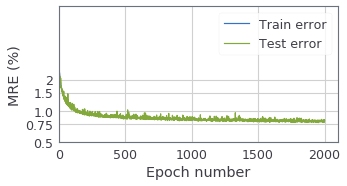

In [7]:
y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))
#history60 = history
plot_training_history(history, 32*2.56)

In [10]:
from keras.models import Model
from keras.layers import Input, Add, AveragePooling1D, MaxPooling1D, Concatenate

a = Input(shape=(8,))
first = Dense(256, kernel_initializer='normal')(a)
#first = Dense(128, kernel_initializer='normal')(first)
#first = BatchNormalization()(first)
first= Activation('relu')(first)

first = Reshape((256,1))(first)
#first = UpSampling1D(size = 2)(first)
first = Conv1D(filters=32, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal', activation='relu')(first)
#first = UpSampling1D(size = 2)(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)



# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)

# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)





first = Reshape((32,256))(first)
first = MaxPooling1D(pool_size=32, strides=None, padding='same')(first)
last = Flatten()(first)

model = Model(inputs=a, outputs=last)
model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K], context=['gpu(0)'])

#model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))


plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model.png')
#plot_model(model, to_file='model.png', )

x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_test, y_test))






/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this

Train on 60000 samples, validate on 40000 samples
Epoch 1/2000


/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


60000/60000 [==============================] - 24s 394us/step - loss: 4209.7176 - calc_mre_K: 25.6984 - val_loss: 2627.7965 - val_calc_mre_K: 16.0388
Epoch 2/2000
60000/60000 [==============================] - 23s 385us/step - loss: 2203.3902 - calc_mre_K: 13.4509 - val_loss: 1408.6241 - val_calc_mre_K: 8.5976
Epoch 3/2000
60000/60000 [==============================] - 23s 386us/step - loss: 935.5657 - calc_mre_K: 5.7116 - val_loss: 773.9411 - val_calc_mre_K: 4.7238
Epoch 4/2000
11584/60000 [====>.........................] - ETA: 16s - loss: 822.8546 - calc_mre_K: 5.0223

KeyboardInterrupt: 

[65 47 39 33 59 38 62 62]


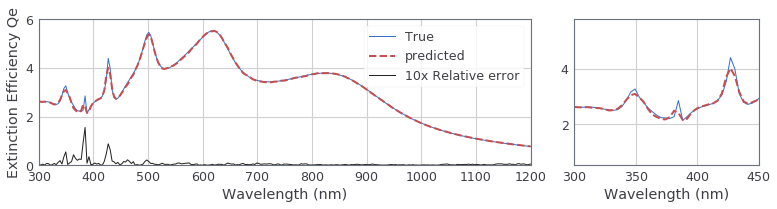

In [100]:
from matplotlib import gridspec
import snlay as snlay
#here we test edge cases where failure happens
#size = np.array([70, 60, 50, 40, 30, 20, 10, 10])
#size = np.array([70, 70, 70, 70, 70, 70, 70, 70])
#size = np.array([30, 30, 30, 30, 30, 30, 30, 30])

#size = np.array([65, 65, 65, 65, 55, 65, 35, 65])
#size = np.array([65, 35, 45, 35, 45, 35, 45, 35])

size = np.random.randint(30, 71, 8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
spec_ac = snlay.calc_spectrum(size, mats, lams)

print(size)


size = (size - 50.0)/20.0



spec = model.predict(np.expand_dims(size, axis = 0))

spec = np.ravel(spec)


fig1 = plt.figure(figsize=(11,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 3]) 

ax = plt.subplot(gs[0])
#ax = fig1.add_subplot(1,2,1)
#ax.set_title('silica coated gold')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Extinction Efficiency Qe')
ax.set_ylim((0, 6))
ax.set_xlim((300, 1200))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'k', linewidth=1, label='10x Relative error')
ax.legend(loc='best')

ax2 = plt.subplot(gs[1])
#fig2 = plt.figure(figsize=(3,3))
#ax2 = fig1.add_subplot(1,2,2)
#ax.set_title('silica coated gold')
ax2.set_xlabel('Wavelength (nm)')
#ax.set_ylabel('Extinction Efficiency Qe')
#ax2.set_ylim((2, 6))
ax2.set_xlim((300, 450))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
#plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'b', linewidth=1, label='10x Relative error')
#ax.legend(loc='best')



plt.tight_layout()
plt.savefig('grid_figure.pdf')






In [49]:
# loop for hundred runs 
import time

mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
#spec_ac = snlay.calc_spectrum(size, mats, lams)

reps = 1000


start = time.time()
for ind in np.arange(reps):
    size = np.random.randint(30, 71, 8)
    #spec_ac = snlay.calc_spectrum(size, mats, lams)
    size = (size - 50.0)/20.0
    spec = model.predict(np.expand_dims(size, axis = 0))
    
    
end = time.time()
print(1000*(end - start)/reps)   
    






1.984304666519165


### Inverse scattering 

In [ ]:


model_d = Sequential()
model_d.add(Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False))

for layer in model.layers:
    model_d.add(layer)

for layer in model_d.layers[1:]:
    layer.trainable = False

for ind in range(1,len(model_d.layers)):
    model_d.layers[ind].set_weights(model.layers[ind-1].get_weights())

model_d.compile(loss=naive_percent_loss, optimizer='adam')    
    
    
#model_d.summary()


# # let us create a target spectrum first
import snlay as snlay
#size = np.array([60, 65, 65, 65, 35, 35, 35, 35])
size = np.random.randint(30,70,8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
target = snlay.calc_spectrum(size, mats, lams)

print(size)

# #do the training here
xd_t = np.ones((1,1))
yd_t = target.reshape(1,250)





history = model_d.fit(xd_t, yd_t,
                    batch_size=1,
                    epochs=5000, 
                    verbose=0)

# #here is the final result
size_out = model_d.get_layer('dummy')
wts = size_out.get_weights()
wts = np.array(wts).ravel()
size_res= 0.5*wts*(size_max - size_min) + size_av
size_res_rounded = np.round(size_res)

spec_zer = model_d.predict(xd_t).ravel()
achieved = snlay.calc_spectrum(size_res_rounded, mats, lams)


fig1 = plt.figure(figsize=(22,5))
ax = fig1.add_subplot(1,1,1)
#plt.plot(lams, spec_zer, label='new model')
plt.plot(lams, target, linewidth=2, label='target')
plt.plot(lams, achieved, '--', linewidth=3, label='achieved')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(size_res_rounded)


### Model shipment

In [ ]:

    
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')



In [ ]:

from keras.models import Model
from keras.layers import Input, Add, Lambda, Dense
import numpy as np


def dropper(x):
    ms = 4
    #print(x.shape)
    
   
    
    return x**2
# msk = np.array([1,1,1,1,0,0,0,0])


a = Input(shape=(1,))
b = Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False)(a)
b = Lambda(dropper)(b)
b = Dense(256)(b)
# #b = Lambda()
# a = Lambda(dropper)(a)
# 

model = Model(inputs=a, outputs=b)

# model = Sequential()
# model.add(Dense(256, input_dim=8))
# #model.add(Lambda(lambda x: x**2))
# model.add(Lambda(dropper))
# model.add(Dense(256))



model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#model.summary()

In [1]:
2 +2 

4

In [2]:
import matplotlib.pyplot as plt